### Struktura danych
1. Tabela (Table) - Podobnie jak w relacyjnej bazie danych – główny kontener na dane.
2. Wiersz (Row) - Każdy wiersz ma unikalny klucz (RowKey). To on decyduje o fizycznym ułożeniu danych i wpływa na wydajność. Dane w tabeli są posortowane według RowKey.
3. Rodzina kolumn (Column Family) - W każdej tabeli definiujesz z góry jedną lub więcej rodzin kolumn (np. data, meta). To fizyczne jednostki przechowywania danych – kolumny tej samej rodziny są trzymane razem na dysku.
4. Kolumna (Qualifier) - Wewnątrz rodziny kolumn możesz dynamicznie tworzyć kolumny, np. data:temperature, data:humidity. Qualifier (np. temperature) nie musi być znany z góry.
5. Wersja (Timestamp) - Każda komórka (row + column) może mieć wiele wersji danych, oznaczonych znacznikiem czasu. Domyślnie zwracana jest najnowsza wersja.

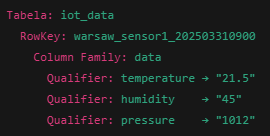

## Ćwiczenia

In [18]:
import happybase
import statistics

### Połączenie z HBase i tworzenie tabeli

In [63]:
connection = happybase.Connection('hbase_nosql_lab', port=9090)
connection.open()

if b'students' in connection.tables():
    print("Tabela już istnieje.")
else:
    connection.create_table(
        'students',
        {'info': dict(), 'grades': dict()}
    )
    print("Utworzono tabelę 'students'.")

print("Dostępne tabele:", connection.tables())


Tabela już istnieje.
Dostępne tabele: [b'students']


### Dodawanie danych do tabeli

In [67]:
table = connection.table('students')

table.put(b'1001', {
    b'info:name': b'Jan Kowalski',
    b'info:email': b'jan.kowalski@example.com',
    b'grades:math': b'15.0',
    b'grades:physics': b'4.5',
})
print("Dodano dane dla studenta 1001.")


Dodano dane dla studenta 1001.


### Odczyt danych z tabeli

In [75]:
row = table.row(b'1001')
print("Dane studenta 1001:", row)

# Odczyt pojedynczej kolumny
math_grade = table.cells(b'1001', b'grades:math')
print("Ocena z matematyki:", math_grade) # Wszystkie wersje
print("Ocena z matematyki:", math_grade[0]) # Ostatnia wersja


Dane studenta 1001: {b'grades:math': b'15.0', b'grades:physics': b'4.5', b'info:email': b'jan.kowalski@example.com', b'info:name': b'Jan Kowalski'}
Ocena z matematyki: [b'15.0', b'5.0', b'5.0']
Ocena z matematyki: b'15.0'


### Skanowanie tabeli

In [76]:
for key, data in table.scan():
    print(f"{key.decode()}: {data}")


1001: {b'grades:math': b'15.0', b'grades:physics': b'4.5', b'info:email': b'jan.kowalski@example.com', b'info:name': b'Jan Kowalski'}
1002: {b'grades:math': b'4.0', b'info:name': b'Anna Nowak'}
1003: {b'grades:math': b'3.5', b'info:name': b'Piotr Zielinski'}


### Usuwanie danych

In [42]:
# Usunięcie jednej kolumny
table.delete(b'1001', columns=[b'grades:physics'])

In [37]:
# Usunięcie całego wiersza
table.delete(b'1001')


### Użycie batch – wsadowe dodawanie danych

In [ ]:
with table.batch() as batch:
    batch.put(b'1002', {b'info:name': b'Anna Nowak', b'grades:math': b'4.0'})
    batch.put(b'1003', {b'info:name': b'Piotr Zielinski', b'grades:math': b'3.5'})
print("Dodano dane wsadowo.")


Dodano dane wsadowo.


### Zaawansowane filtrowanie danych

In [78]:
for key, data in table.scan(filter=b"ValueFilter(=, 'binary:4.0')"):
    print(f"Student z oceną 4.0: {key.decode()}")


Student z oceną 4.0: 1002


### Tworzenie statystyk – średnia ocen

In [80]:
grades = []
for _, data in table.scan(columns=[b'grades:math']):
    if b'grades:math' in data:
        grades.append(float(data[b'grades:math'].decode()))

print("Średnia ocena z matematyki:", statistics.mean(grades))


Średnia ocena z matematyki: 7.5
